## K-Means Clustering

In [1]:
# Libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer

# Visualisation theme
sns.set_theme(style='white')
sns.set_context('notebook')
palette_single = '#7C0000'
palette_binary = {'Male': '#7C0000', 'Female': '#BE8080'}
palette_clusters = ['#FFA800', '#7C0000', '#E89871', '#257575', '#2767E1']

### Load the data and pre-process

In [2]:
# Load data
df = pd.read_csv('data/Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
# Drop `CustomerID` and convert `Gender` to categorical type
customer_id = df.pop('CustomerID')
df['Gender'] = df['Gender'].astype('category')

# Normalise the data
transformer = Normalizer()
X = df[['Annual Income (k$)', 'Spending Score (1-100)']]
X_transformed = transformer.fit_transform(X)

### Step 1: Select k
Select the number of clusters, $k$.

To help us determine the optimum number of clusters, we will be running the algorithm multiple times with different values of $k$ and using the elbow method.

In [4]:
# Initialise the k-means method
wcss = []
cluster_max = int(np.sqrt(X_transformed.shape[0])) + 5

for i in range(1, cluster_max):
    kmeans = KMeans(n_clusters=i, init='random', max_iter=300, random_state=123, algorithm='lloyd').fit(X_transformed)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

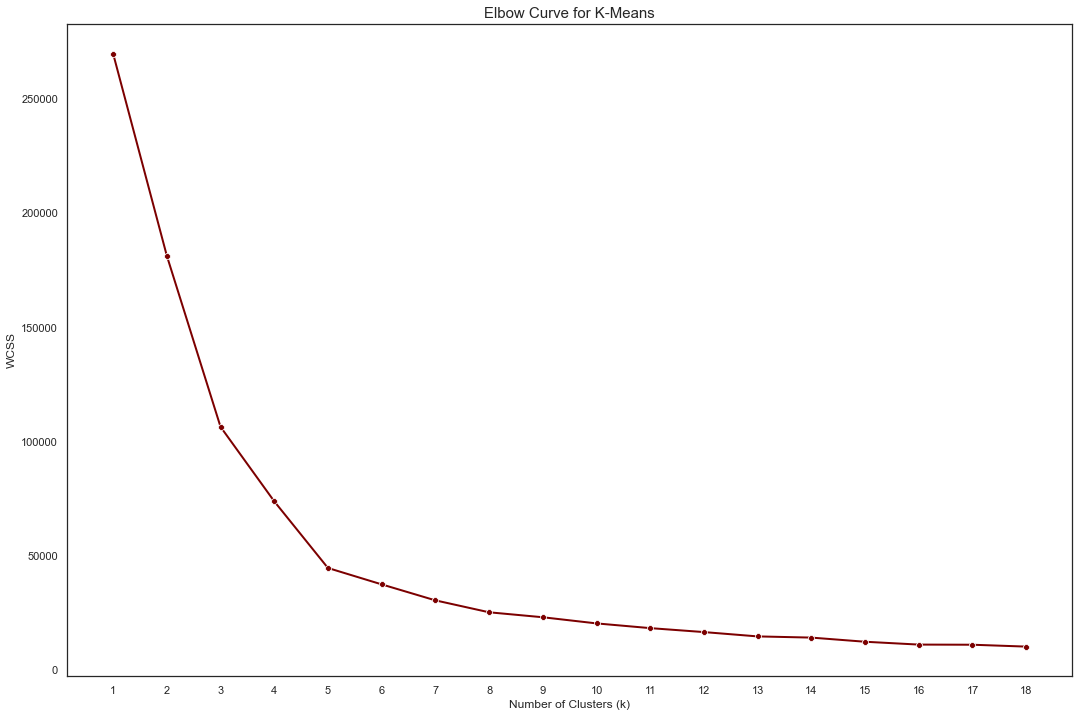

In [5]:
# Plot the elbow curve
plt.figure(figsize=(18,12))
sns.lineplot(x=range(1, cluster_max), y=wcss, linewidth=2, color=palette_single, marker='8')
plt.xlabel('Number of Clusters (k)')
plt.xticks(np.arange(1, cluster_max, 1))
plt.ylabel('WCSS')
plt.title('Elbow Curve for K-Means', size=15)
plt.show()

In [6]:
# Select k
k = 5

# # Fit k-means to the input data with k=5
# kmeans = KMeans(n_clusters=k, init='random', max_iter=300, random_state=123, algorithm='lloyd').fit(X_transformed)
# kmeans.fit(X)

### Step 2: Initialise centroids
Select $k$ cluster centres, either randomly or using a specified initialisation method such as $k$-means++.

For simplicity, we will be using random initialisation in this example.

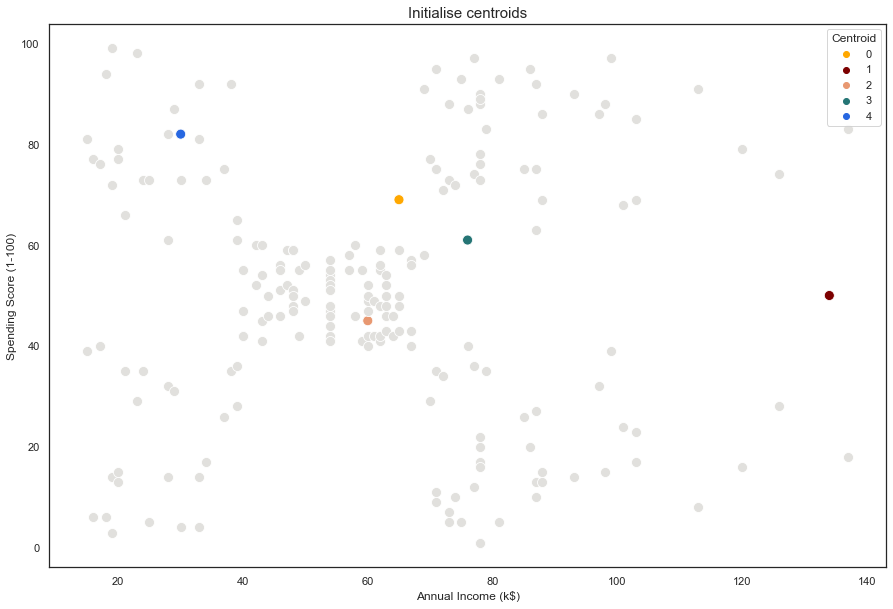

In [7]:
# Randomly select centroids within the given data space
var_x = df['Annual Income (k$)']
var_y = df['Spending Score (1-100)']
min_x, max_x, min_y, max_y = min(var_x), max(var_x), min(var_y), max(var_y)
x = [random.randint(int(min_x), int(max_x)) for n in range(k)]
y = [random.randint(int(min_y), int(max_y)) for n in range(k)]

# Plot the centroids with the data
plt.figure(figsize=(15, 10))
sns.scatterplot(x=x, y=y, palette=palette_clusters, hue=range(5), legend='full', s=100)
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)',
                color='#E1E0DD', legend='full', s=100)
plt.title('Initialise centroids', size=15)
plt.legend(title='Centroid')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

### Step 3: Assign points to clusters
Assign each data point to the cluster with the closest centroid. "Closeness" is defined by an appropriate distance metric, such as the Euclidean distance.

Here, we will define a custom Euclidean distance function to show how it works.

In [8]:
# Custom distance function
def dist_euclidean(x, c):
    """
    x: An array representing an observation in the data.
    c: An array representing the position of the cluster.
    """
    # Get the dimensions of the arrays
    dim_x = x.shape[0]
    dim_c = c.shape[0]
    
    # Only continue if the dimensions are the same
    if dim_x == dim_c:
        # Get the distances between the two points
        distances = []
        distances.append(np.sqrt(np.sum(np.square(np.subtract(x, c)))))
        return np.sum(distances)
    else:
        raise IndexError('The dimensions for x and c are different.')

In [9]:
# Identify the clusters
clusters = []
for c in range(5):
    clusters.append(np.array([x[c], y[c]]))

# Create a dataframe with the distance metrics
df_dist = pd.DataFrame()
df_dist['CustomerID'] = customer_id
df_dist['x'] = df['Annual Income (k$)'].copy()
df_dist['y'] = df['Spending Score (1-100)'].copy()
df_dist['Observation'] = [np.array(df_dist.loc[i, ['x', 'y']]) for i in range(len(df))]

# Add the distances to each cluster
for i, c in enumerate(clusters):
    df_dist[str(i)] = df_dist['Observation'].apply(lambda x: dist_euclidean(x, c))

# Identify the cluster with the smallest distance
cluster_cols = [str(i) for i in range(k)]
df_dist['Cluster'] = df_dist[cluster_cols].idxmin(axis=1)
df_dist

,CustomerID,x,y,Observation,0,1,2,3,4,Cluster
0,1,15,39,"[15, 39]",58.309519,119.507322,45.398238,64.845971,45.541190,2
1,2,15,81,"[15, 81]",51.419841,122.971541,57.628118,64.195015,15.033296,4
2,3,16,6,"[16, 6]",79.812280,125.936492,58.796258,81.394103,77.278716,2
3,4,16,77,"[16, 77]",49.648766,121.049577,54.405882,62.096699,14.866069,4
4,5,17,40,"[17, 40]",56.080300,117.426573,43.289722,62.625873,43.965896,2
...,...,...,...,...,...,...,...,...,...,...
195,196,120,79,"[120, 79]",55.901699,32.202484,68.963759,47.539457,90.049986,1
196,197,126,28,"[126, 28]",73.498299,23.409400,68.154237,59.908263,110.145359,1
197,198,126,74,"[126, 74]",61.204575,25.298221,72.090221,51.662365,96.332757,1
198,199,137,18,"[137, 18]",88.232647,32.140317,81.596569,74.632433,124.679589,1


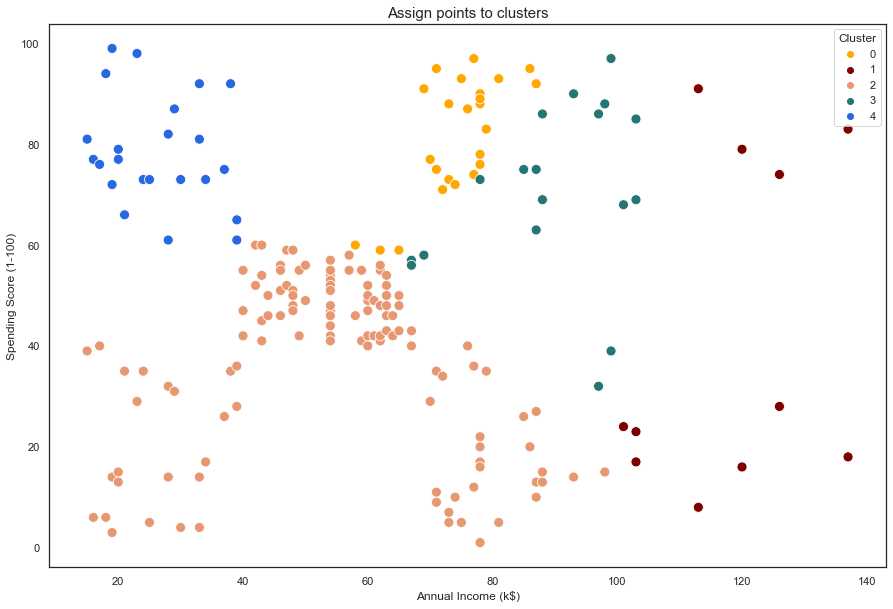

In [10]:
# Assign points to the nearest cluster centroid
plt.figure(figsize=(15, 10))
# sns.scatterplot(x=x, y=y, palette=palette_clusters, hue=range(5), legend='full', s=100)
sns.scatterplot(data=df_dist, x='x', y='y', hue='Cluster', hue_order=['0', '1', '2', '3', '4'],
                palette=palette_clusters, legend='full', s=100)
plt.title('Assign points to clusters', size=15)
plt.legend(title='Cluster')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

### Step 4: Update centroids
After all points have been assigned to clusters, the algorithm updates the cluster centres by taking the mean (or some other measure of central tendency) of the points in each cluster.

We will be using the mean of each cluster but not that this can be swapped out to the median if preferred.

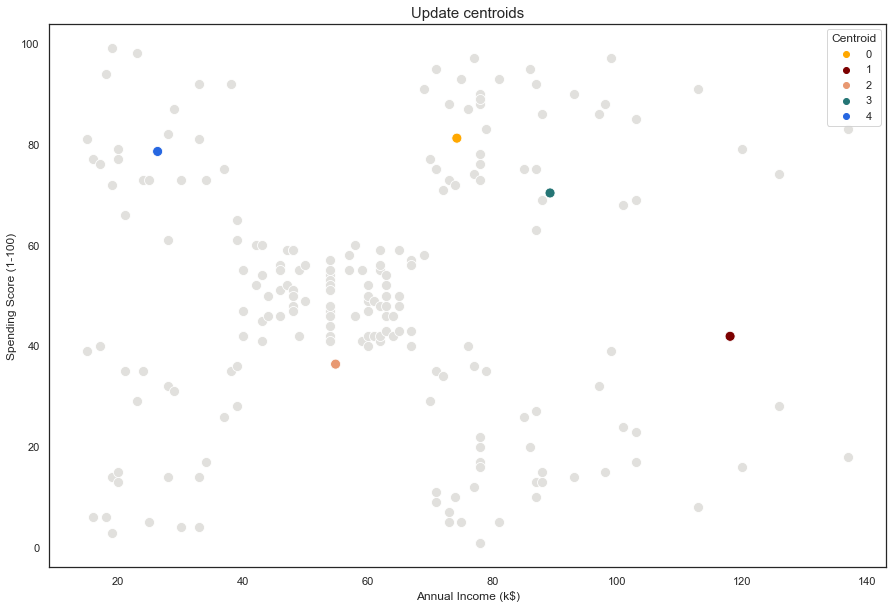

In [11]:
# Get new centroids by taking the cluster means
cluster_means = []
for clust in df_dist['Cluster'].sort_values().unique():
    cluster_means.append(np.mean(df_dist[df_dist['Cluster']==clust]['Observation']))

# Get the x, y values of each centroid
x = [cluster_means[c][0] for c in range(k)]
y = [cluster_means[c][1] for c in range(k)]

# Plot the new centroids with the data
plt.figure(figsize=(15, 10))
sns.scatterplot(x=x, y=y, palette=palette_clusters, hue=range(5), legend='full', s=100)
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)',
                color='#E1E0DD', legend='full', s=100)
plt.title('Update centroids', size=15)
plt.legend(title='Centroid')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

In [12]:
# Assign points to clusters
df_dist2 = df_dist[['CustomerID', 'x', 'y', 'Observation']].copy()
for i, c in enumerate(cluster_means):
    df_dist2[str(i)] = df_dist2['Observation'].apply(lambda x: dist_euclidean(x, c))

# Identify the cluster with the smallest distance
cluster_cols = [str(i) for i in range(k)]
df_dist2['Cluster'] = df_dist[cluster_cols].idxmin(axis=1)
df_dist2

,CustomerID,x,y,Observation,0,1,2,3,4,Cluster
0,1,15,39,"[15, 39]",72.766465,103.131946,39.922790,80.564980,41.148447,2
1,2,15,81,"[15, 81]",59.280337,110.253502,59.808433,74.984772,11.563583,4
2,3,16,6,"[16, 6]",95.139889,108.222070,49.314404,97.469337,73.293181,2
3,4,16,77,"[16, 77]",58.431142,107.953349,56.191599,73.525086,10.422547,4
4,5,17,40,"[17, 40]",70.558050,101.108934,38.009197,78.333649,39.671739,2
...,...,...,...,...,...,...,...,...,...,...
195,196,120,79,"[120, 79]",45.772900,37.140008,77.857279,31.974720,93.696661,1
196,197,126,28,"[126, 28]",74.197024,16.000517,71.655510,56.077768,111.785796,1
197,198,126,74,"[126, 74]",52.218755,33.051175,80.489811,36.960105,99.800122,1
198,199,137,18,"[137, 18]",89.039533,30.482755,84.195571,70.862499,126.181112,1


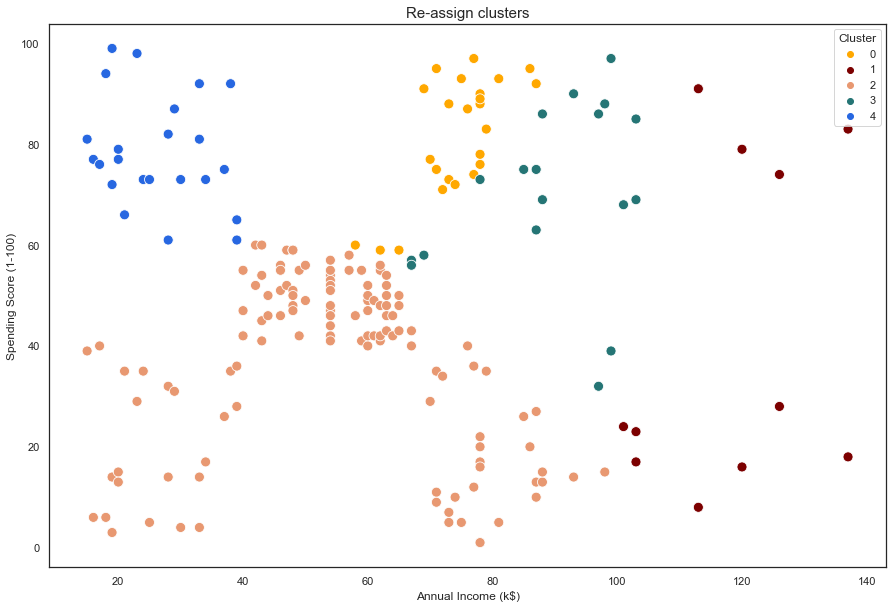

In [13]:
# Plot the new iteration
plt.figure(figsize=(15, 10))
# sns.scatterplot(x=x, y=y, palette=palette_clusters, hue=range(5), legend='full', s=100)
sns.scatterplot(data=df_dist2, x='x', y='y', hue='Cluster', hue_order=['0', '1', '2', '3', '4'],
                palette=palette_clusters, legend='full', s=100)
plt.title('Re-assign clusters', size=15)
plt.legend(title='Cluster')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

### Step 5: Repeat until convergence
The algorithm repeats steps 3 and 4 until the cluster centres stop changing or a specified number of iterations has been reached. That is, if any reassignment took place, go back to step 3 - otherwise, finish the algorithm.

Here, we use the `KMeans` class from `sklearn`.

In [14]:
# Fitting to the input data with k=5
kmeans = KMeans(n_clusters=5,
                init='random',
                max_iter=300,
                random_state=123,
                algorithm='lloyd').fit(X_transformed)
kmeans.fit(X)

# Predict the labels of the input data
df['Cluster'] = kmeans.predict(X)
df.insert(loc=0, column='CustomerID', value=customer_id)
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1,Male,19,15,39,2
1,2,Male,21,15,81,1
2,3,Female,20,16,6,2
3,4,Female,23,16,77,1
4,5,Female,31,17,40,2
...,...,...,...,...,...,...
195,196,Female,35,120,79,0
196,197,Female,45,126,28,3
197,198,Male,32,126,74,0
198,199,Male,32,137,18,3


In [15]:
# Check cluster sizes
pd.DataFrame(df.groupby('Cluster')['CustomerID'].count())

,CustomerID
Cluster,
0,39
1,22
2,23
3,35
4,81


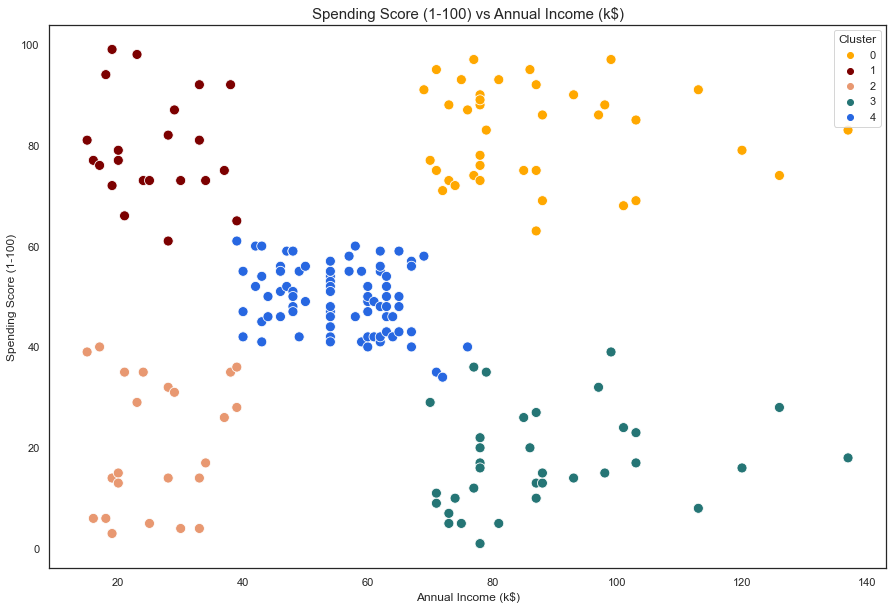

In [16]:
# Scatterplot of the final clusters
plt.figure(figsize=(15, 10))
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster',
                palette=palette_clusters, legend='full', s=100)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('Spending Score (1-100) vs Annual Income (k$)', size=15)
plt.show()

### Finished!
From here on in, we can represent the insights however we need.

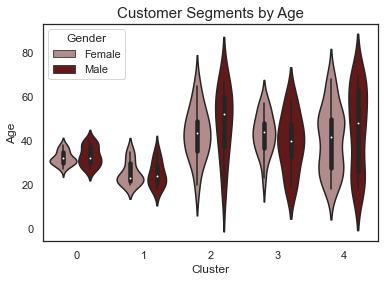

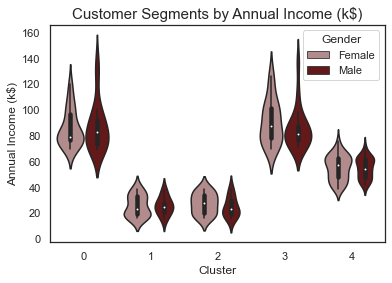

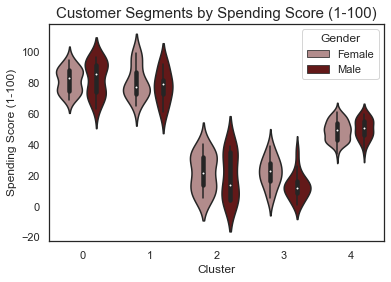

In [17]:
# Visualise the clusters however you like
numeric_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

for var in numeric_cols:
    sns.violinplot(data=df, x='Cluster', y=var, hue='Gender', scale='count', palette=palette_binary, saturation=0.6)
    plt.title('Customer Segments by '+ var, size=15)
    plt.show()